<a href="https://colab.research.google.com/github/shivammehta007/NLPResearch/blob/master/Comparison_of_NLP_Models_IMDB_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# We will compare NLP Models with IMDB Classification

## Imports

In [1]:
import os
import re
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import namedtuple
from pprint import pprint

!pip install -U tqdm
# Need to restart runtime on google collab for it to work

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm
from torchtext import datasets
from torchtext import data

from spacy.lang.en import English
nlp = English()
# Create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.Defaults.create_tokenizer(nlp)
%matplotlib inline

     |████████████████████████████████| 61kB 6.4MB/s 
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


## Seed Set

In [0]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
random.seed(SEED)

# Load the Data

## TorchText Data

Initialize two Field and Label 

In [0]:
TEXT = data.Field(tokenize=tokenizer)
LABEL = data.LabelField(dtype = torch.float)

In [4]:
%%time
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:09<00:00, 8.94MB/s]


CPU times: user 1min 30s, sys: 10.3 s, total: 1min 40s
Wall time: 1min 51s


In [5]:
print(len(train_data), len(test_data))
print(vars(train_data.examples[0]))

25000 25000
{'text': This is an absurdist dark comedy from Belgium. Shot perfectly in crisp black and white, Benoît Poelvoorde (Man Bites Dog) is on fine form as Roger, the angry, obsessive father of a family in a small, sullen Belgian mining town. Roger is a photographer who, along with his young daughter Luise, visits road accidents to take photos. He is also obsessed with winning a car by entering a competition where the contestant has to break a record - and he decides that his son, Michel, must attempt to break the record of perpetually walking through a door - he even hires an overweight coach to train him. Michel dresses as Elvis and has a spot on a radio show called 'Cinema Lies', where he describes mistakes in films. Luise is friendly with near neighbour Felix, a pigeon fancier. Roger is a callous figure as he pushes Michel right over the limit during the record attempt, which almost results in his death. Interspersed throughout the film are Magritte-like surreal images. It's 

In [0]:
train_data, valid_data = train_data.split(split_ratio=0.8, random_state=random.seed(SEED))

In [7]:
print(f'Train Data: \t\t {len(train_data):,}')
print(f'Validation Dataset: \t {len(valid_data):,}')
print(f'Test Data: \t\t {len(test_data):,}')

Train Data: 		 20,000
Validation Dataset: 	 5,000
Test Data: 		 25,000


## Pandas DataFrame
We Converted Data to DataFrame for implementation of Classical Algorithms

In [8]:
type(train_data.examples[0].text)

spacy.tokens.doc.Doc

In [0]:
def get_dataframe_from_dataset(dataset, labels = {'X': 'text', 'y': 'label'}):
    """Utility Method to convert torchext.data.Dataset to numpy array of text and label"""
    i = 0
    data = {'X' : [], 'y' : []}
    for example in tqdm(dataset):
        data['X'].append(example.text.text)
        data['y'].append(example.label)
    
    assert len(data['X']) == len(data['y'])

    return pd.DataFrame(data).rename(columns=labels)


In [10]:
train_df = get_dataframe_from_dataset(train_data)
val_df = get_dataframe_from_dataset(valid_data)
test_df = get_dataframe_from_dataset(test_data)

In [11]:
test_df.head()

,text,label
0,Hehehe. This was one of the best funny road mo...,pos
1,"This movie is good for entertainment purposes,...",pos
2,Corniness Warning. As many fellow IMDb users a...,pos
3,This movie starts off somewhat slowly and gets...,pos
4,I got some free tickets via the Times to see t...,pos


# Implementation

## Classical ML algorithms
First Step will be **Preprocessing**
### List of Algorithms Implemented
1.   Naïve Bais Classifier
2.   Random Forest Classifier
3.   Support Vector Machines (SVM) Linear
4.   SGD Classifiers
5.   XGBoost
6.   Lightgbm



## Pre Processing

### Steps:

1.   Decontract
2.   Stopwords Removal
3.   Punctuation Removal
4.   Vectorize
5.   Label Encode



In [0]:
dataframes = [train_df, val_df, test_df]

#### 1. Decontract

In [0]:
def decontracted(text):
    # specific
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)

    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [0]:
for df in dataframes:
    df['text'] = df['text'].apply(decontracted)

#### 2. Stopwords Removal

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stopwords = set(stopwords.words("english"))

In [0]:
def remove_stopwords(text):
    """Removes Stopwords from the text uses scapy tokenizer little heavy but good"""
    text = ' '.join([word.text for word in tokenizer(text) if word.text not in stopwords])
    return text

In [18]:
for df in tqdm(dataframes):
    df['text'] = df['text'].apply(remove_stopwords)

#### 3. Punctuation Removal

In [0]:
from string import punctuation

def remove_punctuation(text):
    text = text.translate(str.maketrans('', '', punctuation))
    return text

In [20]:
for df in tqdm(dataframes):
    df['text'] = df['text'].apply(remove_punctuation)

#### 4. Vectorize
from Sklearn.feature_extraction.text import:
1.   CountVectorizer
2.   TfIdfVectorizer



In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

We will use them later ! In sklearn.pipeline.Pipleline !!

#### 5. Encode Label

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [23]:
for df in tqdm(dataframes):
    df['label'] = le.fit_transform(df['label'])

In [24]:
train_df.head()

,text,label
0,honestly I begin This low budget HORRIBLY a...,0
1,This one unusual cases movie novel based great...,1
2,Words seriously enough convey emotional power ...,1
3,In August 1980 disappearance baby Azaria Chamb...,1
4,Oh dear I disappointed movie rip Japan Ringu...,0


### Converting to Numpy arrays 
For faster computation and generic variable names

In [0]:
split_df = lambda df: (np.array(df['text']), np.array(df['label']))

In [0]:
X_train, y_train = split_df(train_df)
X_valid, y_valid = split_df(val_df)
X_test, y_test = split_df(test_df)

## Pipeline of Algorithms

#### Support Methods

In [0]:
def get_predictions_and_accuracy(X_test):
    y_pred = best_model.pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print('Test Accuracy: {:.4f}%'.format(test_accuracy * 100))
    report = pd.DataFrame(classification_report(y_pred, y_test, target_names=['neg', 'pos'], output_dict=True))
    print(report)
    sns.heatmap(report.iloc[:-1:].T, annot=True)
    plt.title('Classification Report')
    plt.show()

In [0]:
from sklearn.pipeline import Pipeline

In [0]:
Model = namedtuple('Model', ['pipeline', 'predictions', 'accuracy'])

### 1. Naïve Bais Classifier

In [0]:
from sklearn.naive_bayes import MultinomialNB

#### Generating Pipelines
Generate two pipelines with differenet Vectorizers, whichever will show better performance over valid set, we will tune Hyperparameters over it

In [0]:
naive_bais1 = Pipeline(
    [('cv', CountVectorizer()),
      ('nb', MultinomialNB())])

naive_bais2 = Pipeline(
    [('tfidf', TfidfVectorizer()),
      ('nb', MultinomialNB())])

In [32]:
best_accuracy = 0.0
best_model = Model(None, None, None)
for pipeline in tqdm([naive_bais1, naive_bais2]):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[0] for step in best_model.pipeline.steps], best_model.accuracy*100))


Best Pipeline found: ['tfidf', 'nb'] with accuracy: 86.92%


Test Accuracy: 83.4680%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.892320      0.777040   0.83468      0.834680      0.841325
recall         0.800086      0.878289   0.83468      0.839188      0.834680
f1-score       0.843690      0.824568   0.83468      0.834129      0.835231
support    13941.000000  11059.000000   0.83468  25000.000000  25000.000000


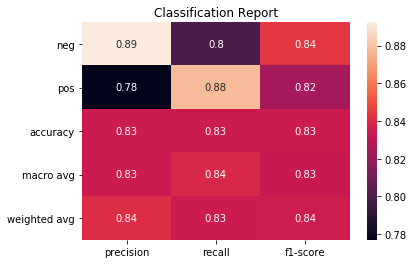

In [33]:
get_predictions_and_accuracy(X_test)

#### Tune Hyperparameters
We will use ParameterSearch since we already have validation set else we would have used GridSearchCV

In [0]:
parameters = {
    'ngram_range': [(1, 1), (1, 2), (1, 3), (2, 3)]
}
parameters = ParameterGrid(parameters)

In [35]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline(
        [('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('nb', MultinomialNB())])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameter: {}'.format(accuracy * 100, parameter['ngram_range']))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 86.92 Parameter: (1, 1)
Accuracy: 88.10 Parameter: (1, 2)
Accuracy: 88.28 Parameter: (1, 3)
Accuracy: 87.08 Parameter: (2, 3)

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)] with accuracy: 88.28%


#### Test Set Results

Test Accuracy: 86.2480%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.905120      0.819840   0.86248      0.862480      0.866116
recall         0.833997      0.896274   0.86248      0.865136      0.862480
f1-score       0.868104      0.856355   0.86248      0.862230      0.862730
support    13566.000000  11434.000000   0.86248  25000.000000  25000.000000


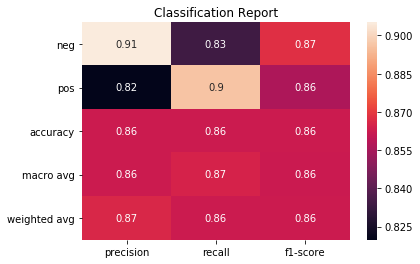

In [36]:
get_predictions_and_accuracy(X_test)

### 2. Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
tf = TfidfVectorizer()
tf_x_train = tf.fit_transform(X_train)
accuracy = accuracy_score(RandomForestClassifier().fit(tf_x_train, y_train).predict(tf.transform(X_valid)), y_valid)
print('Base Accuracy: {:.4f}'.format(accuracy * 100))

Base Accuracy: 84.5400


In [0]:
parameters = {
    'ngram_range': [(1, 2)],
    'max_depth': [None],
    'n_estimators': [300, 1000],
    'n_jobs' : [-1]
}

parameters = ParameterGrid(parameters)

In [40]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline(
        [('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('rfc', RandomForestClassifier(
                    max_depth=parameter['max_depth'],
                    n_estimators=parameter['n_estimators']
                                      ))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameters: {}'.format(accuracy * 100, parameter))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 86.50 Parameters: {'max_depth': None, 'n_estimators': 300, 'n_jobs': -1, 'ngram_range': (1, 2)}
Accuracy: 87.18 Parameters: {'max_depth': None, 'n_estimators': 1000, 'n_jobs': -1, 'ngram_range': (1, 2)}

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_i

Test Accuracy: 86.6760%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.885840      0.847680   0.86676      0.866760      0.867488
recall         0.853279      0.881311   0.86676      0.867295      0.866760
f1-score       0.869255      0.864168   0.86676      0.866711      0.866809
support    12977.000000  12023.000000   0.86676  25000.000000  25000.000000


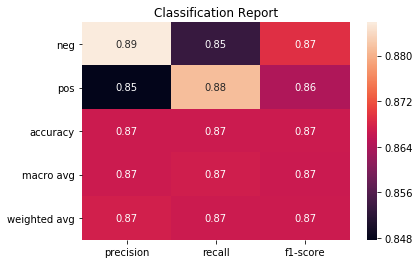

In [41]:
get_predictions_and_accuracy(X_test)

### 3. SVC

In [0]:
from sklearn.svm import LinearSVC

In [0]:
parameters = {
    'ngram_range': [(1, 2)],
    'penalty': ['l2'],
    'C' : [1.0, 2.0, 3.0]
}

parameters = ParameterGrid(parameters)

In [44]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline(
        [('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('svc', LinearSVC(penalty=parameter['penalty'],
                          C=parameter['C']))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameters: {}'.format(accuracy * 100, parameter))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 89.84 Parameters: {'C': 1.0, 'ngram_range': (1, 2), 'penalty': 'l2'}
Accuracy: 90.00 Parameters: {'C': 2.0, 'ngram_range': (1, 2), 'penalty': 'l2'}
Accuracy: 90.00 Parameters: {'C': 3.0, 'ngram_range': (1, 2), 'penalty': 'l2'}

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None), LinearSVC(C=2.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)] with accuracy

Test Accuracy: 89.3040%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.893920      0.892160   0.89304      0.893040      0.893042
recall         0.892349      0.893733   0.89304      0.893041      0.893040
f1-score       0.893134      0.892946   0.89304      0.893040      0.893040
support    12522.000000  12478.000000   0.89304  25000.000000  25000.000000


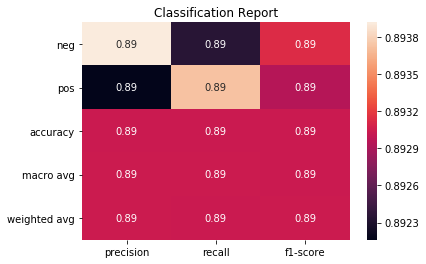

In [45]:
get_predictions_and_accuracy(X_test)

### 4. SGD Classifier

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
parameters = {
    'ngram_range': [(1,1), (1, 2)],
    'penalty': ['l2', 'elasticnet'],
    'alpha': [1e-3, 1e-4],
    'n_jobs' : [-1]
}

parameters = ParameterGrid(parameters)

In [48]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline(
        [('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('sgd', SGDClassifier(penalty=parameter['penalty'],
                          alpha=parameter['alpha'],
                          n_jobs=parameter['n_jobs']))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameters: {}'.format(accuracy * 100, parameter))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 84.90 Parameters: {'alpha': 0.001, 'n_jobs': -1, 'ngram_range': (1, 1), 'penalty': 'l2'}
Accuracy: 82.38 Parameters: {'alpha': 0.001, 'n_jobs': -1, 'ngram_range': (1, 1), 'penalty': 'elasticnet'}
Accuracy: 81.88 Parameters: {'alpha': 0.001, 'n_jobs': -1, 'ngram_range': (1, 2), 'penalty': 'l2'}
Accuracy: 78.88 Parameters: {'alpha': 0.001, 'n_jobs': -1, 'ngram_range': (1, 2), 'penalty': 'elasticnet'}
Accuracy: 88.98 Parameters: {'alpha': 0.0001, 'n_jobs': -1, 'ngram_range': (1, 1), 'penalty': 'l2'}
Accuracy: 88.72 Parameters: {'alpha': 0.0001, 'n_jobs': -1, 'ngram_range': (1, 1), 'penalty': 'elasticnet'}
Accuracy: 89.52 Parameters: {'alpha': 0.0001, 'n_jobs': -1, 'ngram_range': (1, 2), 'penalty': 'l2'}
Accuracy: 87.92 Parameters: {'alpha': 0.0001, 'n_jobs': -1, 'ngram_range': (1, 2), 'penalty': 'elasticnet'}

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
              

Test Accuracy: 88.6400%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.885440      0.887360    0.8864      0.886400      0.886402
recall         0.887143      0.885660    0.8864      0.886401      0.886400
f1-score       0.886291      0.886509    0.8864      0.886400      0.886400
support    12476.000000  12524.000000    0.8864  25000.000000  25000.000000


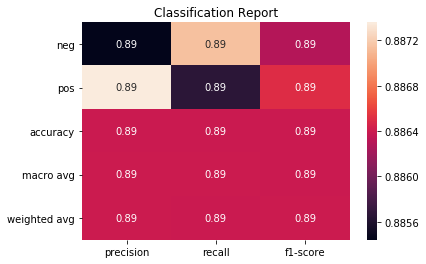

In [49]:
get_predictions_and_accuracy(X_test)

### 5. XGBoost
Ah! The power of Gradient Boosted tree :D

In [0]:
import xgboost as xgb

In [0]:
parameters = {
    'ngram_range': [(1, 2)],
    'max_depth' : [3, 4, 5],
    'n_estimators' : [100, 150]
}

parameters = ParameterGrid(parameters)

In [62]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline(
        [('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('xgb', xgb.XGBClassifier(objective="binary:logistic",
            max_depth=parameter['max_depth'],
            n_estimators=parameter['n_estimators']
        ))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameters: {}'.format(accuracy * 100, parameter))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 80.98 Parameters: {'max_depth': 3, 'n_estimators': 100, 'ngram_range': (1, 2)}
Accuracy: 82.34 Parameters: {'max_depth': 3, 'n_estimators': 150, 'ngram_range': (1, 2)}
Accuracy: 82.16 Parameters: {'max_depth': 4, 'n_estimators': 100, 'ngram_range': (1, 2)}
Accuracy: 83.08 Parameters: {'max_depth': 4, 'n_estimators': 150, 'ngram_range': (1, 2)}
Accuracy: 81.92 Parameters: {'max_depth': 5, 'n_estimators': 100, 'ngram_range': (1, 2)}
Accuracy: 83.26 Parameters: {'max_depth': 5, 'n_estimators': 150, 'ngram_range': (1, 2)}

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
           

Test Accuracy: 83.7400%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.814240      0.860560    0.8374      0.837400      0.838473
recall         0.853787      0.822463    0.8374      0.838125      0.837400
f1-score       0.833545      0.841081    0.8374      0.837313      0.837487
support    11921.000000  13079.000000    0.8374  25000.000000  25000.000000


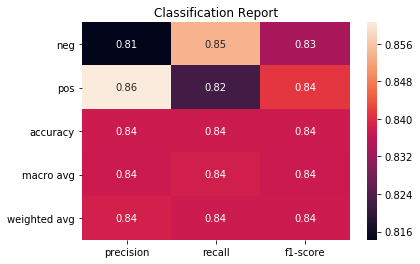

In [63]:
get_predictions_and_accuracy(X_test)

### 6. LightGBM

In [0]:
import lightgbm as lgbm

In [0]:
parameters = {
    'ngram_range': [(1, 2)],
    "objective": ["binary"],
    "metric": ["binary_logloss"],
    "max_depth" : [-1, 7],
    "num_leaves": [31, 70],
    "verbose": [-1],
    "n_jobs": [-1]
    }
parameters = ParameterGrid(parameters)

In [72]:
best_model = Model(None, None, None)
best_accuracy = 0
for parameter in tqdm(list(parameters)):
    pipeline = Pipeline([('tfidf', TfidfVectorizer(ngram_range=parameter['ngram_range'])),
        ('lgbm', lgbm.LGBMClassifier(
            objective=parameter['objective'],
            metric=parameter['metric'],
            max_depth=parameter['max_depth'],
            num_leaves=parameter['num_leaves'],
            verbose=parameter['verbose']
        ))])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    print('Accuracy: {:.2f} Parameters: {}'.format(accuracy * 100, parameter))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = Model(pipeline, y_pred, accuracy)

print('Best Pipeline found: {} with accuracy: {:.2f}%'.format([step[1] for step in best_model.pipeline.steps], best_model.accuracy*100))

Accuracy: 86.32 Parameters: {'max_depth': -1, 'metric': 'binary_logloss', 'n_jobs': -1, 'ngram_range': (1, 2), 'num_leaves': 31, 'objective': 'binary', 'verbose': -1}
Accuracy: 86.78 Parameters: {'max_depth': -1, 'metric': 'binary_logloss', 'n_jobs': -1, 'ngram_range': (1, 2), 'num_leaves': 70, 'objective': 'binary', 'verbose': -1}
Accuracy: 82.92 Parameters: {'max_depth': 7, 'metric': 'binary_logloss', 'n_jobs': -1, 'ngram_range': (1, 2), 'num_leaves': 31, 'objective': 'binary', 'verbose': -1}
Accuracy: 83.24 Parameters: {'max_depth': 7, 'metric': 'binary_logloss', 'n_jobs': -1, 'ngram_range': (1, 2), 'num_leaves': 70, 'objective': 'binary', 'verbose': -1}

Best Pipeline found: [TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smoo

Test Accuracy: 86.9680%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.870400      0.868960   0.86968      0.869680      0.869681
recall         0.869148      0.870213   0.86968      0.869681      0.869680
f1-score       0.869774      0.869586   0.86968      0.869680      0.869680
support    12518.000000  12482.000000   0.86968  25000.000000  25000.000000


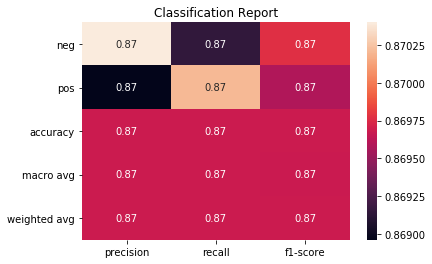

In [73]:
get_predictions_and_accuracy(X_test)

### **Voting Classifier**
Merging few of major classifiers and running them on a voting basis

In [0]:
from sklearn.ensemble import VotingClassifier

In [0]:
voting_classifier = VotingClassifier(estimators=[
                        ('nb' , MultinomialNB()),
                        ('rfc', RandomForestClassifier()),
                        ('svc', LinearSVC(penalty='l2', C=0.2)),
                        ('sgd', SGDClassifier(penalty='l2', alpha=0.0001))
                    ])

In [37]:
pipeline = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('vc', voting_classifier)
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfid',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(...
                                                             early_stopping=False,
                                                             epsilon=0.1,
                                                             eta0=0.0,
                                                             fit_intercept

In [41]:
y_pred = pipeline.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)
print('Accuracy: {:.2f}'.format(accuracy * 100))
best_model = Model(pipeline, y_pred, accuracy)

Accuracy: 88.94


Test Accuracy: 87.4600%
                    neg           pos  accuracy     macro avg  weighted avg
precision      0.911680      0.837520    0.8746      0.874600      0.877350
recall         0.848738      0.904606    0.8746      0.876672      0.874600
f1-score       0.879084      0.869771    0.8746      0.874427      0.874773
support    13427.000000  11573.000000    0.8746  25000.000000  25000.000000


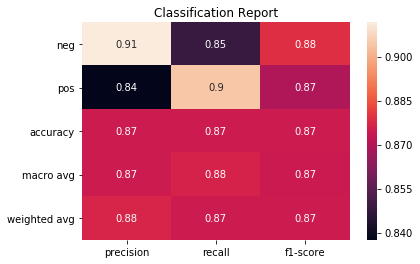

In [42]:
get_predictions_and_accuracy(X_test)